# Shakespeare & Company Analysis

---

https://shakespeareandco.princeton.edu/

In 1919, an American woman named Sylvia Beach (1887 – 1962) opened an English-language bookshop and lending library on the Left Bank in Paris. She called it Shakespeare and Company, and it quickly became the center of expatriate life in the city. In 1922, she published James Joyce’s Ulysses under the Shakespeare and Company imprint, making the bookshop and lending library famous around the world. Over the next two decades, she sold and loaned books—everything from the avant-garde poetry to birth control manuals to the latest philosophy. In 1941, she closed the bookshop and lending library during the German occupation of France. Shakespeare and Company would never reopen, but she continued to loan books from her apartment until her death.

The Shakespeare and Company Project uses the records of Sylvia Beach’s famous bookshop and lending library to reveal the reading practices of many of the century’s most influential writers, along with hundreds of other artists, intellectuals, and students who lived in Paris between the two world wars.

---

## Import

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib_venn import venn2
from scipy.stats import entropy, iqr
import numpy as np
import networkx as nx
from networkx.algorithms.community import girvan_newman
import geopandas as gpd
import contextily as ctx

In [33]:
def load_data(file_path, dtype=None):
    """
    Load data from a CSV file.

    Parameters:
    file_path (str): Path to the CSV file
    dtype (dict): Dictionary specifying the data types of columns

    Returns:
    pd.DataFrame: Loaded DataFrame
    """
    try:
        return pd.read_csv(file_path, encoding='utf-8', dtype=dtype, low_memory=False)
    except FileNotFoundError:
        print(f"Error: The file {file_path} was not found.")
        return pd.DataFrame()
    except pd.errors.ParserError:
        print(f"Error: Could not parse the file {file_path}.")
        return pd.DataFrame()

# Load the datasets
books = load_data('../data/SCoData_books_v1.2_2022_01.csv', dtype={'year': 'Int32'})
members = load_data('../data/SCoData_members_v1.2_2022_01.csv')
events = load_data('../data/SCoData_events_v1.2_2022_01.csv')

## Intersection of Authors and Members

In [34]:
# Filter books of format 'Book', select relevant columns, and drop rows with any missing values
book_authors = books[books['format'] == 'Book'][['author']].dropna()

# Remove duplicate entries to ensure all authors are unique across the dataset
unique_authors = book_authors.drop_duplicates(subset=['author'])

# Display the shape of the resulting DataFrame.
print(unique_authors.shape)

(1995, 1)


In [35]:
# Filter members, remove duplicates and missing values
member_filtered = members[['sort_name']].dropna().drop_duplicates(subset=['sort_name'])

# Rename column for merging
unique_members = member_filtered.rename(columns={'sort_name': 'member'})

# Merge authors and members to find common entries
merged_df = pd.merge(unique_members, unique_authors, how='inner', left_on='member', right_on='author')

# Rename column for clarity
member_is_author = merged_df[['member']].rename(columns={'member': 'name'})

### Venn Diagram of Authors and Members

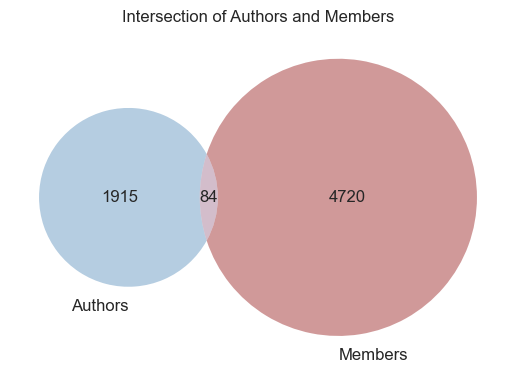

In [36]:
# Extract unique authors and members
unique_authors_set = set(books['author'])
unique_members_set = set(members['sort_name'])

# Calculate the intersection
intersection_count = len(unique_authors_set.intersection(unique_members_set))

# Create the Venn diagram for authors with customized colors
venn = venn2(subsets=(len(unique_authors_set) - intersection_count, len(unique_members_set) - intersection_count, intersection_count),
             set_labels=('Authors', 'Members'),
             set_colors=('steelblue', 'darkred'))

# Customize Venn diagram labels
for subset in venn.subset_labels:
    if subset:
        subset.set_fontsize(12)

plt.title('Intersection of Authors and Members')
plt.show()

In [37]:
# Calculate the percentages
percent_intersection_authors = (intersection_count / len(unique_authors_set)) * 100
percent_intersection_members = (intersection_count / len(unique_members_set)) * 100

print(f'Percent of the intersection relative to authors: {percent_intersection_authors:.2f}%')
print(f'Percent of the intersection relative to members: {percent_intersection_members:.2f}%')

Percent of the intersection relative to authors: 4.20%
Percent of the intersection relative to members: 1.75%


In [38]:
# Extract the rows from 'members' where 'sort_name' matches 'name' in 'member_is_author'
matched_members = members[members['sort_name'].isin(member_is_author['name'])]

## Geographic Distribution of Member-Authors

In [39]:
# Split the coordinates and create a new DataFrame
coordinate_list = matched_members['coordinates'].str.split(';').explode()

# Create a DataFrame from the exploded list
coordinates_df = coordinate_list.str.split(',', expand=True)
coordinates_df.columns = ['latitude', 'longitude']

# Convert to numeric values
coordinates_df['latitude'] = pd.to_numeric(coordinates_df['latitude'].str.strip())
coordinates_df['longitude'] = pd.to_numeric(coordinates_df['longitude'].str.strip())

# Add the sort_name column to the coordinates DataFrame
coordinates_df = coordinates_df.join(pd.DataFrame(np.repeat(matched_members['sort_name'].values, coordinate_list.groupby(level=0).size()), columns=['sort_name']))

# Display the resulting DataFrame
print(coordinates_df)

      latitude  longitude              sort_name
45    48.84835    2.34269       Ford, Ford Madox
83    48.85908    2.32429           Joyce, James
94    48.85092    2.33845           Joyce, James
101   48.88241    2.27120  Le Gallienne, Richard
122   48.83907    2.33162        McAlmon, Robert
...        ...        ...                    ...
5057  48.84151    2.34177                    NaN
5057  48.85459    2.33696                    NaN
5098  48.85527    2.32557                    NaN
5109  48.85074    2.33427                    NaN
5180  48.88504    2.26120                    NaN

[164 rows x 3 columns]


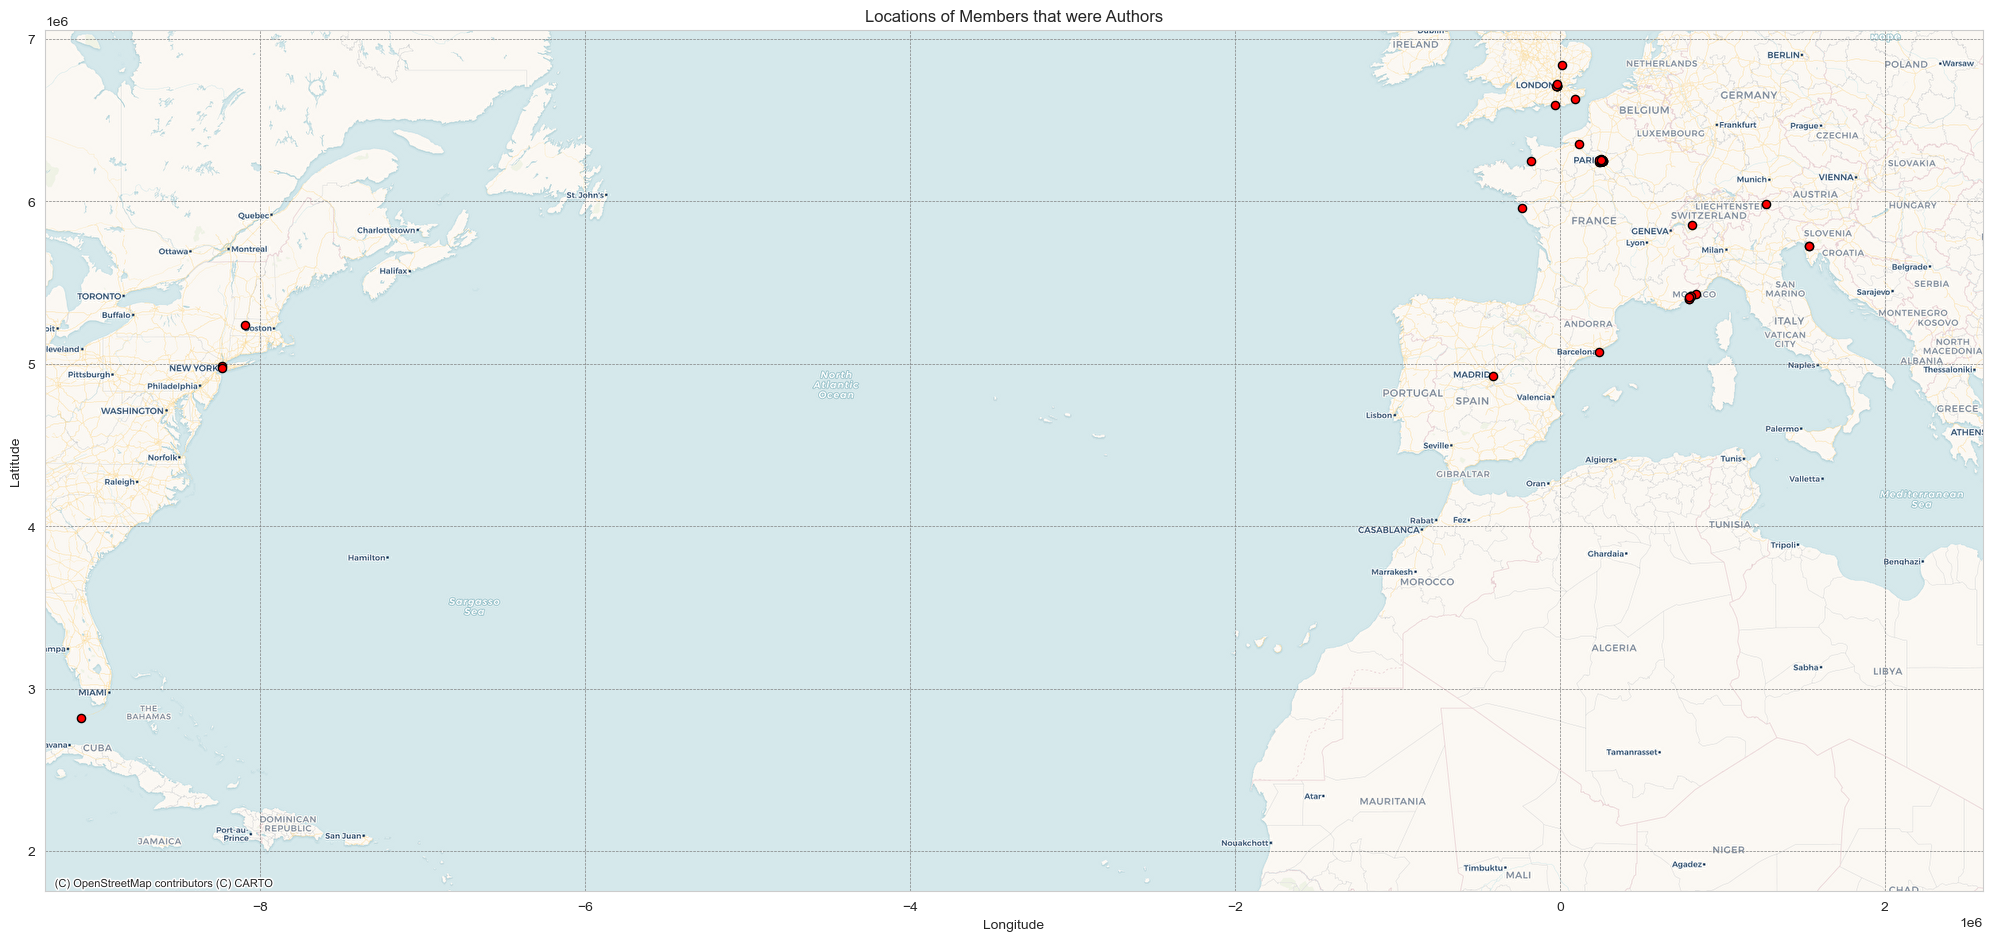

In [47]:
# Load the map of the world
world_map = gpd.read_file('../data/world.shp')

# Ensure the world_map has a CRS; if not, set it to EPSG:4326 (WGS84)
if world_map.crs is None:
    world_map.set_crs(epsg=4326, inplace=True)

# Create a GeoDataFrame from the coordinates
gdf = gpd.GeoDataFrame(coordinates_df, geometry=gpd.points_from_xy(coordinates_df.longitude, coordinates_df.latitude))

# Set the coordinate reference system (CRS) for your GeoDataFrame and reproject both to EPSG 3857 (Web Mercator)
gdf = gdf.set_crs(epsg=4326).to_crs(epsg=3857)
world_map = world_map.to_crs(epsg=3857)

# Function to plot the map
def plot_map(gdf, world_map, minx, miny, maxx, maxy, title, zoom):
    fig, ax = plt.subplots(figsize=(25, 14))
    world_map.plot(ax=ax, edgecolor='darkgray', linewidth=0.5, alpha=0)
    gdf.plot(ax=ax, marker='o', color='red', markersize=35, edgecolor='black')
    ax.set_xlim(minx, maxx)
    ax.set_ylim(miny, maxy)
    ax.set_title(title)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.grid(True, which='both', color='gray', linestyle='--', linewidth=0.5)
    ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.CartoDB.Voyager, zoom=zoom, interpolation='sinc')
    plt.show()

# Plotting the world map
minx, miny, maxx, maxy = gdf.total_bounds
plot_map(gdf, world_map, minx - 220000, maxx + 220000, miny - 220000, maxy + 220000, 'Locations of Members that were Authors', 5)


### Geographic Distribution of Member-Authors (USA)

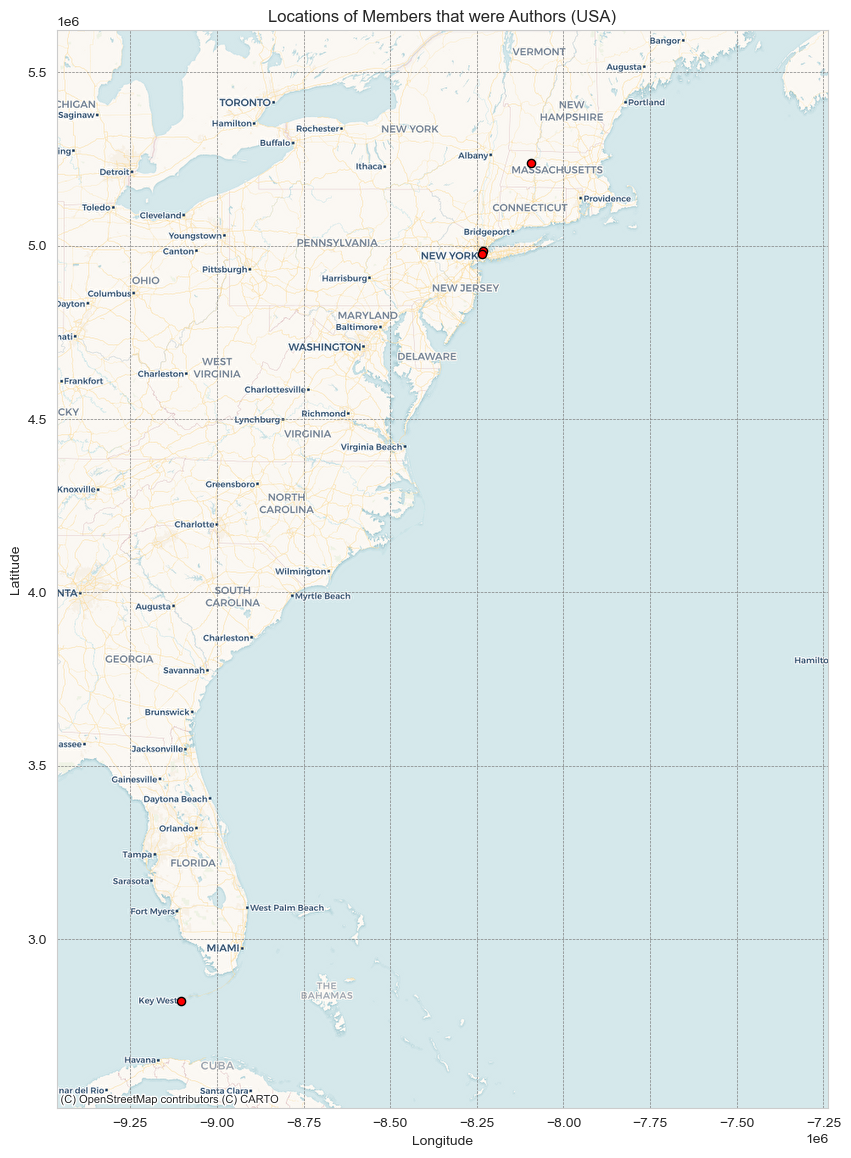

In [48]:
# Convert original EPSG:4326 (longitude, latitude) limits to EPSG:3857 (meters) for USA
transformer = Transformer.from_crs("epsg:4326", "epsg:3857", always_xy=True)
minx_3857, miny_3857 = transformer.transform(-85, 22)  # Lower-left corner
maxx_3857, maxy_3857 = transformer.transform(-65, 45)  # Upper-right corner

# Plotting the USA map
plot_map(gdf, world_map, minx_3857, miny_3857, maxx_3857, maxy_3857, 'Locations of Members that were Authors (USA)', 6)

### Geographic Distribution of Member-Authors (Europe)

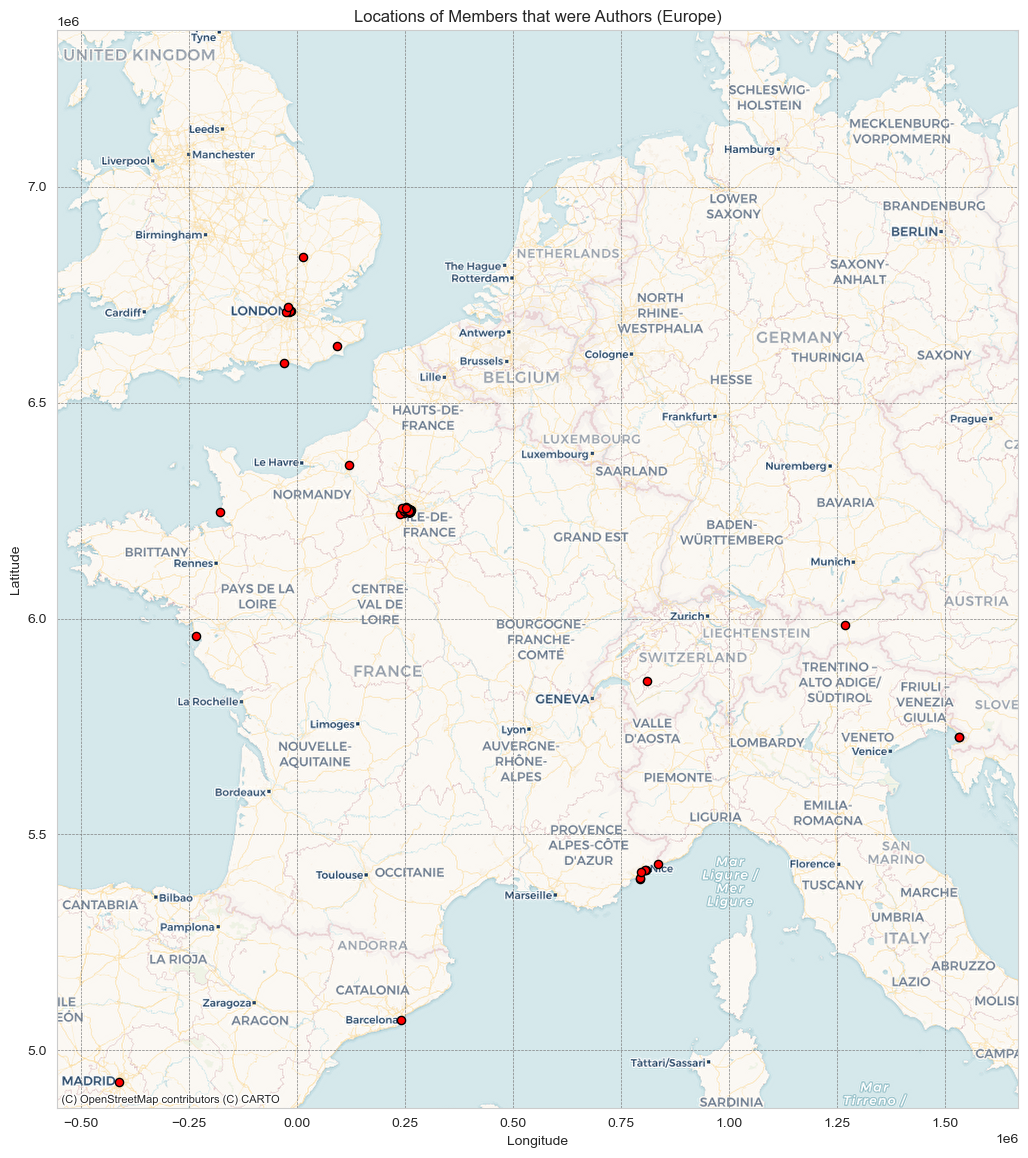

In [49]:
# Convert original EPSG:4326 (longitude, latitude) limits to EPSG:3857 (meters)
transformer = Transformer.from_crs("epsg:4326", "epsg:3857", always_xy=True)
minx_3857, miny_3857 = transformer.transform(-5, 40)  # Lower-left corner
maxx_3857, maxy_3857 = transformer.transform(15, 55)  # Upper-right corner

# Plotting the USA map
plot_map(gdf, world_map, minx_3857, miny_3857, maxx_3857, maxy_3857, 'Locations of Members that were Authors (Europe)', 6)


## Mapping of Common Adresses

In [53]:
# Split, normalize, and clean addresses, then create a new DataFrame
addresses_df = matched_members.assign(addresses=matched_members['addresses'].str.split(';')).explode('addresses')
addresses_df['addresses'] = addresses_df['addresses'].str.strip()

# Group by addresses to find common addresses and filter to find addresses with more than one resident
common_addresses = addresses_df.groupby('addresses').agg(names=('name', ', '.join)).reset_index()
common_addresses = common_addresses[common_addresses['names'].str.contains(',')]

# Display the result
common_addresses

,addresses,names
10,"12 rue de l'Odéon, Paris","George Antheil, Sylvia Beach, Padraic Colum, R..."
46,"34 rue des Vignes, Paris","Pierre de Lanux, James Joyce"
49,"4 boulevard Raspail, Paris","Stephen Vincent Benét, Margaret Wilson"
65,"6 via Cesare Battista, Trieste","James Joyce, Stanislaus Joyce"
69,"69 rue Raynouard, Paris","Élisabeth de Gramont, Duchesse de Clermont-Ton..."
75,"71 rue du Cardinal Lemoine, Paris","James Joyce, Valery Larbaud"
99,"Hotel Jacob, 44 rue Jacob, Paris","David Gascoyne, Ernest Hemingway"
142,"Select Hôtel, 1 place de la Sorbonne, Paris","Richard Aldington, Katherine Mansfield"
149,"École normale supérieure, 45 rue d'Ulm, Paris","Samuel Beckett, Thomas MacGreevy"


In [44]:
members_addresses_coordinates = pd.read_csv('../data/author-members.csv', sep = ';', encoding='utf-8')

In [57]:
# Ensure the 'addresses' column is of type string and handle NaN values
matched_members['addresses'] = matched_members['addresses'].astype(str).fillna('')

# Split, normalize, and clean addresses, then create a new DataFrame
addresses_df = matched_members.assign(addresses=matched_members['addresses'].str.split(';')).explode('addresses')
addresses_df['addresses'] = addresses_df['addresses'].str.strip()

# Group by addresses to find common addresses and filter to find addresses with more than one resident
common_addresses = addresses_df.groupby('addresses').agg(names=('name', ', '.join)).reset_index()
common_addresses = common_addresses[common_addresses['names'].str.contains(',')]

# Display the result
print(common_addresses)

                                         addresses  \
10                        12 rue de l'Odéon, Paris   
46                        34 rue des Vignes, Paris   
49                      4 boulevard Raspail, Paris   
65                  6 via Cesare Battista, Trieste   
69                         69 rue Raynouard, Paris   
75               71 rue du Cardinal Lemoine, Paris   
99                Hotel Jacob, 44 rue Jacob, Paris   
142    Select Hôtel, 1 place de la Sorbonne, Paris   
148                                            nan   
150  École normale supérieure, 45 rue d'Ulm, Paris   

                                                 names  
10   George Antheil, Sylvia Beach, Padraic Colum, R...  
46                        Pierre de Lanux, James Joyce  
49              Stephen Vincent Benét, Margaret Wilson  
65                       James Joyce, Stanislaus Joyce  
69   Élisabeth de Gramont, Duchesse de Clermont-Ton...  
75                         James Joyce, Valery Larbaud  
99    

C:\Users\dittm\AppData\Local\Temp\ipykernel_13192\2087686419.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_members['addresses'] = matched_members['addresses'].astype(str).fillna('')


In [59]:
import pandas as pd

# Helper function to reformat "LastName, FirstName" to "FirstName LastName"
def reorder_name(name):
    parts = name.split(', ')
    if len(parts) == 2:
        return f"{parts[1]} {parts[0]}"
    return name

# Helper function to join names in a readable way
def readable_join(names):
    if len(names) > 1:
        return ', '.join(names[:-1]) + ', ' + names[-1]
    else:
        return names[0]

# Assuming DataFrame is called coordinates_df
# Step 1: Group by latitude and longitude, filter those that appear more than once
grouped_df = coordinates_df.groupby(['latitude', 'longitude']).filter(lambda x: len(x) > 1)

# Step 2: Group again, reformat names, and aggregate in a readable format
result_df = grouped_df.groupby(['latitude', 'longitude']).agg(
    names=('sort_name', lambda x: readable_join(sorted([reorder_name(name) for name in x]))),  # Reformat names
    count=('sort_name', 'size')  # Count the number of people
).reset_index()

# View the result
print(result_df)

AttributeError: 'float' object has no attribute 'split'

In [58]:
# Drop the first row which contains the NaN values
result_df = result_df.drop(index=0)

NameError: name 'result_df' is not defined

In [ ]:
from pyproj import Transformer

# Load the map of the world (or Paris in this case)
paris_map = gpd.read_file('../data/world.shp')

# Ensure the paris_map has a CRS; if not, set it to EPSG:4326 (WGS84)
if paris_map.crs is None:
    paris_map.set_crs(epsg=4326, inplace=True)  # Set it to WGS84 if it's missing

# Create a GeoDataFrame from the coordinates (assuming 'names' is a column with unique names)
gdf = gpd.GeoDataFrame(result_df,
                       geometry=gpd.points_from_xy(result_df.longitude,
                                                   result_df.latitude))

# Set the coordinate reference system (CRS) for your GeoDataFrame
gdf.set_crs(epsg=4326, inplace=True)  # EPSG 4326 is WGS84 latitude-longitude

# Reproject both to EPSG 3857 (Web Mercator)
gdf = gdf.to_crs(epsg=3857)
paris_map = paris_map.to_crs(epsg=3857)

# Convert original EPSG:4326 (longitude, latitude) limits to EPSG:3857 (meters)
transformer = Transformer.from_crs("epsg:4326", "epsg:3857", always_xy=True)
minx_3857, miny_3857 = transformer.transform(2.27, 48.83)  # Lower-left corner
maxx_3857, maxy_3857 = transformer.transform(2.36, 48.87)  # Upper-right corner

# Create a color palette with one color for each unique name
unique_names = gdf['names'].unique()
palette = sns.color_palette("Set1", len(unique_names))  # seaborn palette for variety

# Create a dictionary mapping names to colors
name_to_color = dict(zip(unique_names, palette))

# Plotting
fig, ax = plt.subplots(figsize=(13, 9))

# Plot Paris map and scatter points
paris_map.plot(ax=ax, edgecolor='darkgray', linewidth=0.5, alpha=0)

# Plot points with different colors
for name, color in name_to_color.items():
    subset = gdf[gdf['names'] == name]  # Filter GeoDataFrame by name
    subset.plot(ax=ax, marker='o', color=[color], markersize=70, edgecolor='black', label=name)

# Set limits for the axes using projected coordinates (in meters)
ax.set_xlim(minx_3857, maxx_3857)
ax.set_ylim(miny_3857, maxy_3857)

# Add a title, labels, and grid
ax.set_title('Locations of Members that were Authors')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.grid(True, which='both', color='gray', linestyle='--', linewidth=0.5)

# Add a legend to show names with corresponding colors
ax.legend(title='Author-members with the same address', loc='upper left', bbox_to_anchor=(1, 1), fancybox=True, title_fontproperties={'weight':'bold'}, labelspacing = 1.5)

# Add a basemap with specified zoom level for clarity
ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.CartoDB.Voyager, zoom=14, interpolation='sinc')

# Display the plot
plt.show()

THE NEXT CODE IS NOT DESCRIBED IN THESIS YET

In [ ]:
from pyproj import Transformer

# Load the map of the world (or Paris in this case)
paris_map = gpd.read_file('../data/world.shp')

# Ensure the paris_map has a CRS; if not, set it to EPSG:4326 (WGS84)
if paris_map.crs is None:
    paris_map.set_crs(epsg=4326, inplace=True)  # Set it to WGS84 if it's missing

# Create a GeoDataFrame from the coordinates (assuming 'names' is a column with unique names)
gdf = gpd.GeoDataFrame(coordinates_df,
                       geometry=gpd.points_from_xy(coordinates_df.longitude,
                                                   coordinates_df.latitude))

# Set the coordinate reference system (CRS) for your GeoDataFrame
gdf.set_crs(epsg=4326, inplace=True)  # EPSG 4326 is WGS84 latitude-longitude

# Reproject both to EPSG 3857 (Web Mercator)
gdf = gdf.to_crs(epsg=3857)
paris_map = paris_map.to_crs(epsg=3857)

# Convert original EPSG:4326 (longitude, latitude) limits to EPSG:3857 (meters)
transformer = Transformer.from_crs("epsg:4326", "epsg:3857", always_xy=True)
minx_3857, miny_3857 = transformer.transform(2.27, 48.83)  # Lower-left corner
maxx_3857, maxy_3857 = transformer.transform(2.36, 48.87)  # Upper-right corner

# Increase the limits to zoom out
buffer_x = (maxx_3857 - minx_3857) * 1.3  # 20% buffer on x-axis
buffer_y = (maxy_3857 - miny_3857) * 1.3  # 20% buffer on y-axis

# Create the expanded limits
minx_3857 -= buffer_x
maxx_3857 += buffer_x
miny_3857 -= buffer_y
maxy_3857 += buffer_y

# Plotting
fig, ax = plt.subplots(figsize=(13, 9))

# Plot Paris map and scatter points
paris_map.plot(ax=ax, edgecolor='darkgray', linewidth=0.5, alpha=0)
gdf.plot(ax=ax, marker='o', color='red', edgecolor='black', markersize=30)

# Set limits for the axes using expanded projected coordinates (in meters)
ax.set_xlim(minx_3857, maxx_3857)
ax.set_ylim(miny_3857, maxy_3857)

# Add a title, labels, and grid
ax.set_title('Locations of Members that were Authors')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.grid(True, which='both', color='gray', linestyle='--', linewidth=0.5)

# Add a basemap with specified zoom level for clarity
ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.CartoDB.VoyagerNoLabels, zoom=13, interpolation='sinc')
ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.CartoDB.VoyagerOnlyLabels, zoom=12, interpolation='sinc')

# Display the plot
plt.show()

## Statistical Analysis

### Nationalities

In [ ]:
matched_members.nationalities.sample(20)

In [ ]:
# Handling NaN
matched_members['nationalities'] = matched_members['nationalities'].fillna('Unknown')

# Splitting multiple nationalities
# This will create a new row for each nationality in cases where there are multiple nationalities separated by ';'
df = matched_members.drop('nationalities', axis=1).join(
    matched_members['nationalities'].str.split(';', expand=True).stack().reset_index(level=1, drop=True).rename('nationalities')
)

print(df)

In [ ]:
nationality_counts = df['nationalities'].value_counts()

# Plotting
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=nationality_counts.index, y=nationality_counts.values, palette='Paired')
plt.title('Frequency of Nationalities')
plt.xlabel('Nationalities')
plt.ylabel('Number of Members')
plt.xticks(rotation=45)
for i, count in enumerate(nationality_counts.values):
    ax.text(i, count, str(count), ha='center', va='bottom', fontsize=9)
plt.show()

THE NEXT CODE IS NOT YET DESCRIBED IN THESIS

In [ ]:
percentages = df['nationalities'].value_counts(normalize=True) * 100
print(percentages)

In [ ]:
mode_nationalities = df['nationalities'].value_counts().idxmax() # mode
print(f"Mode of nationalities distribution: {mode_nationalities}")

In [ ]:
# Assuming `members` DataFrame and 'gender' column exist
nationalities_counts = df['nationalities'].value_counts(normalize=True)
entropy_nationalities = entropy(nationalities_counts)

# Calculate the number of unique categories (genders)
num_categories = nationalities_counts.size

# Calculate the maximum possible entropy
max_entropy = np.log(num_categories)

# Print the entropy and the benchmark
print(f"Entropy of nationalities distribution: {entropy_nationalities}")
print(f"Maximum possible entropy with {num_categories} categories: {max_entropy}")

# Calculate the normalized entropy (entropy divided by maximum possible entropy)
normalized_entropy = entropy_nationalities / max_entropy

print(f"Normalized entropy: {normalized_entropy}")

### Gender

In [ ]:
count_gender = matched_members['gender'].value_counts().sort_index()  # operate on series ; count

In [ ]:
plt.figure(figsize=(4, 6))
ax = sns.barplot(x=count_gender.index, y=count_gender.values, palette='Paired')
plt.title('Distribution of Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.xticks(rotation=45)
for i, count in enumerate(count_gender.values):
    ax.text(i, count, str(count), ha='center', va='bottom', fontsize=9)

plt.show()

THE NEXT CODE IS NOT YET DESCRIBED IN THESIS

In [ ]:
percentages = matched_members['gender'].value_counts(normalize=True) * 100
print(percentages)

In [ ]:
mode_gender = matched_members['gender'].value_counts().idxmax() # mode
print(f"Mode of gender distribution: {mode_gender}")

In [ ]:
# Assuming `members` DataFrame and 'gender' column exist
gender_counts = matched_members['gender'].value_counts(normalize=True)
entropy_gender = entropy(gender_counts)

# Calculate the number of unique categories (genders)
num_categories = gender_counts.size

# Calculate the maximum possible entropy
max_entropy = np.log(num_categories)

# Print the entropy and the benchmark
print(f"Entropy of gender distribution: {entropy_gender}")
print(f"Maximum possible entropy with {num_categories} categories: {max_entropy}")

# Calculate the normalized entropy (entropy divided by maximum possible entropy)
normalized_entropy = entropy_gender / max_entropy

print(f"Normalized entropy: {normalized_entropy}")

### Birth Years

In [ ]:
# Cleaning: Remove NaN values
df = matched_members.dropna(subset=['birth_year'])

# Convert birth_year to integer
df['birth_year'] = df['birth_year'].astype(int)

# Plotting a boxplot
plt.figure(figsize=(8, 6))
plt.boxplot(df['birth_year'], vert=False)  # 'vert=False' makes the boxplot horizontal
plt.title('Boxplot for Birth Years')
plt.xlabel('Birth Year')
plt.grid(True)
plt.show()

THE NEXT CODE IS NOT YET DESCRIBED IN THESIS

In [ ]:
print(matched_members['birth_year'].mean())
print(matched_members['birth_year'].median())
print(matched_members['birth_year'].mode())

In [ ]:
# Group birth years into bins (e.g., by decade)
matched_members['birth_year_group'] = pd.cut(matched_members['birth_year'], bins=np.arange(1850, 1920, 10))

# Calculate the normalized value counts for each bin
birth_year_group_counts = matched_members['birth_year_group'].value_counts(normalize=True)

# Calculate the entropy of the birth year distribution
entropy_birth_year = entropy(birth_year_group_counts)

# Calculate the number of unique bins
num_bins = birth_year_group_counts.size

# Calculate the maximum possible entropy
max_entropy = np.log(num_bins)

# Calculate the normalized entropy
normalized_entropy = entropy_birth_year / max_entropy

# Print the results
print(f"Entropy of birth year distribution: {entropy_birth_year}")
print(f"Maximum possible entropy with {num_bins} bins: {max_entropy}")
print(f"Normalized entropy: {normalized_entropy}")

THE NEXT CODE IS NOT YET DESCRIBED IN THESIS

In [ ]:
# Calculate the percentage for each birth year group
birth_year_group_percentages = birth_year_group_counts * 100

# Sort by decade for better readability
birth_year_group_percentages = birth_year_group_percentages.sort_index()

# Display the percentages in plain text
for decade, percentage in birth_year_group_percentages.items():
    print(f"{decade}: {percentage:.2f}%")

### Books

THE NEXT CODE IS NOT YET DESCRIBED IN THESIS

In [ ]:
books_by_member = books[books['author'].isin(member_is_author['name'])]

# Filter books to only include those published until 1941
#books_until_1941 = books[books['year'] <= 1941]
#books_by_member_until_1941 = books_by_member[books_by_member['year'] <= 1941]

# Calculate the number of unique titles (assuming no duplicates in the original dataset)
total_unique_titles = len(books['title'].unique())
unique_titles_by_member = len(books_by_member['title'].unique())

# Calculate the percentage of unique titles by members out of the total
percentage_of_books_by_members = (unique_titles_by_member / total_unique_titles) * 100

# Prepare a dictionary with the results
book_counts_summary = {
    'Total Books': total_unique_titles,
    'Books by Members': unique_titles_by_member,
    'Percentage of Books by Members': f'{percentage_of_books_by_members:.2f}%'
}

# Display the dictionary
book_counts_summary

In [ ]:
# Filter the books dataframe to keep only the rows where the author is in the list of authors who are members

# Drop rows with missing values in the 'year' column for both datasets
books = books.dropna(subset=['year'])
books_by_member = books_by_member.dropna(subset=['year'])

# Convert 'year' to integer (or the appropriate type if not already)
books['year'] = books['year'].astype(int)
books_by_member['year'] = books_by_member['year'].astype(int)

# Filter books to only include those published until 1941
#books_until_1941 = books[books['year'] <= 1941]
#books_by_member_until_1941 = books_by_member[books_by_member['year'] <= 1941]

# Prepare data for plotting
all_books = books['year']
member_books = books_by_member['year']

# Plot the stacked histogram
plt.figure(figsize=(10, 7))
plt.hist([all_books, member_books], bins=30, stacked=True, label=['Total Books', 'Books by Members'], color=['cornflowerblue', 'darkorange'])
plt.xlabel('Publication Year')
plt.ylabel('Number of Books')
plt.title('Stacked Histogram of Books by Publication Year (Until 1941)')
plt.legend()
plt.show()

In [ ]:
# Group the dataframe by 'author' and count the number of titles for each author
books_count_by_author = books_by_member.groupby('author').count()['title'].sort_values(ascending=False)

# Optionally, you might want to reset the index to make the data more presentable
books_count_by_author = books_count_by_author.reset_index()
books_count_by_author.columns = ['author', 'numberOfBooks']

# Display the result
print(books_count_by_author)

DESCRIBE THE CALC OF IQR IN THE NEXT CODE

In [ ]:
number_of_books = books_count_by_author['numberOfBooks'].values
n = len(number_of_books)

# Calculate the interquartile range (IQR)
iqr_value = iqr(number_of_books)

# Calculate the number of bins using the Freedman-Diaconis rule
fd_bins = int(np.ptp(number_of_books) / (2 * (iqr_value / (n ** (1/3)))))

# Plot histogram
plt.figure(figsize=(12, 8))
plt.hist(number_of_books, bins=fd_bins, color='skyblue', edgecolor='black')
plt.title(f'Freedman-Diaconis Rule (bins={fd_bins})')
plt.xlabel('Number of Books')
plt.ylabel('Number of Authors')
plt.show()

In [ ]:
# Filter events to include only those where the member is an author and the event type is 'Borrow'
borrow_events_by_author = events[(events['member_sort_names'].isin(member_is_author['name'])) & (events['event_type'] == 'Borrow')]

# Display a random sample of the filtered events
borrow_events_by_author.sample(1)

## Network Analysis

### All Books

#### Pivot Table

In [ ]:
# Create a pivot table with users as rows, books as columns, and counts of borrow events as values
user_book_matrix = borrow_events_by_author.pivot_table(index='member_sort_names', columns='item_title', aggfunc='size', fill_value=0)

print(user_book_matrix.tail(2))

#### Network Graph

FORGOT TO MENTION NODES AND EDGES NUMBER

In [ ]:
# Create an empty graph
G = nx.Graph()

# Add nodes and edges based on the user-book matrix
for user1 in user_book_matrix.index:
    for user2 in user_book_matrix.index:
        if user1 != user2:
            # Calculate intersection of books borrowed by both users
            common_books = sum((user_book_matrix.loc[user1] > 0) & (user_book_matrix.loc[user2] > 0))
            if common_books > 0:
                G.add_edge(user1, user2, weight=common_books)

print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())

In [ ]:
# Set the random seed for reproducibility
np.random.seed(42)

plt.figure(figsize=(12, 12))
pos = nx.kamada_kawai_layout(G)  # Positions for all nodes
nx.draw_networkx_nodes(G, pos, node_size=600, node_color='lightblue')
nx.draw_networkx_edges(G, pos, width=[G[u][v]['weight'] for u,v in G.edges()], alpha=0.5)
nx.draw_networkx_labels(G, pos, font_size=10)
plt.title('Network of Users Borrowing the Same Books')
plt.show()

In [ ]:
edge_weights = nx.get_edge_attributes(G,'weight')

In [ ]:
plt.figure(figsize=(12, 12))
pos = nx.kamada_kawai_layout(G)  # Positions for all nodes
nx.draw_networkx_nodes(G, pos, node_size=600, node_color='lightblue')
nx.draw_networkx_edges(G, pos, width=list(edge_weights.values()))
nx.draw_networkx_edge_labels(G, pos,edge_labels=edge_weights)
nx.draw_networkx_labels(G, pos, font_size=10)
plt.title('Network of Users Borrowing the Same Books')
plt.show()

In [ ]:
dict(G.degree())

In [ ]:
plt.bar(range(len(dict(G.degree()))), list(dict(G.degree()).values()), align='center')
plt.xticks(range(len(dict(G.degree()))), list(dict(G.degree()).keys()))
plt.xticks(rotation=90)
plt.ylabel('Degree')
plt.show()

In [ ]:
dict(G.degree(weight='weight'))

In [ ]:
# weighted degree
plt.bar(range(len(dict(G.degree(weight='weight')))), list(dict(G.degree(weight='weight')).values()), align='center')
plt.xticks(range(len(dict(G.degree(weight='weight')))), list(dict(G.degree(weight='weight')).keys()))
plt.xticks(rotation=90)
plt.ylabel('Weighted Degree')
plt.show()

#### Neighbors

In [ ]:
# neighbors of Hemingway, Ernest
list(nx.neighbors(G,'Hemingway, Ernest'))

In [ ]:
# neighbors of Joyce, James
list(nx.neighbors(G,'Joyce, James'))

In [ ]:
# neighbors of Stein, Gertrude
list(nx.neighbors(G,'Stein, Gertrude'))

In [ ]:
# Create subgraph of Hemingway's neighbors
hemingway_neighbors=nx.subgraph(G,list(nx.neighbors(G,'Hemingway, Ernest')))

In [ ]:
dict(hemingway_neighbors.degree(weight='weight'))

In [ ]:
# Visualization
plt.figure(figsize=(15, 8))

# Using the Kamada-Kawai layout
pos = nx.spring_layout(hemingway_neighbors, weight=None, k=0.8)

# Drawing the nodes
nx.draw_networkx_nodes(hemingway_neighbors, pos, node_size=300, node_color='skyblue', alpha=0.6, edgecolors='black')

# Drawing the edges
nx.draw_networkx_edges(hemingway_neighbors, pos, width=2, alpha=0.5, edge_color='gray')

# Drawing the labels
nx.draw_networkx_labels(hemingway_neighbors, pos, font_size=10, font_color='black')

# Add a title
plt.title('Network of Authors Borrowing the Same Books As Hemingway', size=15)

# Show plot
plt.show()

In [ ]:
# Create subgraph of Joyce's neighbors
joyce_neighbors=nx.subgraph(G,list(nx.neighbors(G,'Joyce, James')))

In [ ]:
# Visualization
plt.figure(figsize=(15, 8))

# Using the Kamada-Kawai layout
pos = nx.spring_layout(joyce_neighbors, weight=None, k=0.8)

# Drawing the nodes
nx.draw_networkx_nodes(joyce_neighbors, pos, node_size=300, node_color='skyblue', alpha=0.6, edgecolors='black')

# Drawing the edges
nx.draw_networkx_edges(joyce_neighbors, pos, width=2, alpha=0.5, edge_color='gray')

# Drawing the labels
nx.draw_networkx_labels(joyce_neighbors, pos, font_size=10, font_color='black')

# Add a title
plt.title('Network of Authors Borrowing the Same Books As Joyce', size=15)

# Show plot
plt.show()

In [ ]:
cluster_coeff=nx.clustering(G)
plt.bar(range(len(cluster_coeff)), list(cluster_coeff.values()), align='center')
plt.xticks(range(len(cluster_coeff)), list(cluster_coeff.keys()))
plt.xticks(rotation=90)
plt.ylabel('Clustering Coefficient')
plt.show()

In [ ]:
# number of nodes
# number of members
len(G.nodes())

In [ ]:
# number of edges
# number of relationships
len(G.edges())

In [ ]:
# density
nx.density(G)

In [ ]:
# diameter
nx.diameter(G)

In [ ]:
# average shortest path length
nx.average_shortest_path_length(G)

In [ ]:
# assortativity
nx.assortativity.degree_assortativity_coefficient(G)

In [ ]:
# average clustering coefficient
nx.average_clustering(G)

In [ ]:
# small worldness is defined as the ratio between average clustering coefficient and average shortest path length,
# relative to an equivalent random graph
print(nx.average_clustering(G)/nx.average_shortest_path_length(G))

In [ ]:
nx.algorithms.smallworld.sigma(G,niter=10,nrand=5)

In [ ]:
clique=list(nx.clique.find_cliques(G))

In [ ]:
len(clique)

In [ ]:
clique

#### Community Detection

In [ ]:
communities=list(nx.community.label_propagation_communities(G))

node_color_number=[]
for node in G:
    for community in range(len(communities)):
        if str(node) in communities[community]:
            node_color_number.append(community)

# Create a figure with a specified size
plt.figure(figsize=(12, 12))

# Generate positions for each node using the spring layout
pos = nx.kamada_kawai_layout(G)

# Draw nodes with a color map
nx.draw_networkx_nodes(G, pos, node_size=600, node_color=node_color_number, cmap=plt.cm.Set3)

# Draw edges and edge labels with specified widths
edge_weights = nx.get_edge_attributes(G, 'weight')  # Ensure edge weights are obtained correctly
nx.draw_networkx_edges(G, pos, width=list(edge_weights.values()))
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_weights)

# Draw node labels
nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')

# Set the title of the plot
plt.title('Network of Users Borrowing the Same Books')

# Display the plot
plt.show()

In [ ]:
communities_louvain = list(nx.community.louvain_communities(G, seed=42))

node_color_number_louvain=[]
for node in G:
    for community in range(len(communities_louvain)):
        if str(node) in communities_louvain[community]:
            node_color_number_louvain.append(community)

# Create a figure with a specified size
plt.figure(figsize=(12, 12))

# Generate positions for each node using the spring layout
pos = nx.kamada_kawai_layout(G)

# Draw nodes with a color map
nx.draw_networkx_nodes(G, pos, node_size=600, node_color=node_color_number_louvain, cmap=plt.cm.Set3)

# Draw edges and edge labels with specified widths
edge_weights = nx.get_edge_attributes(G, 'weight')  # Ensure edge weights are obtained correctly
nx.draw_networkx_edges(G, pos, width=list(edge_weights.values()))
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_weights)

# Draw node labels
nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')

# Set the title of the plot
plt.title('Network of Users Borrowing the Same Books')

# Display the plot
plt.show()

#### Author-Members and All Books

In [ ]:
# Convert pivot table to edge list
edge_list = user_book_matrix.stack().reset_index()
edge_list.columns = ['member_sort_names', 'item_title', 'borrowed']
edge_list = edge_list[edge_list['borrowed'] > 0]

# Filter books that were only borrowed once overall
book_counts = edge_list['item_title'].value_counts()
books_multi_borrowed = book_counts[book_counts > 1].index
edge_list = edge_list[edge_list['item_title'].isin(books_multi_borrowed)]

# Create a graph from the edge list
G_T = nx.from_pandas_edgelist(edge_list, source='item_title', target='member_sort_names', create_using=nx.Graph())

# Visualization
plt.figure(figsize=(15, 8))
pos = nx.kamada_kawai_layout(G_T)  # Positions for all nodes
#0.3
#0.6

# Assign colors to nodes
node_colors = ['lightsteelblue' if node in edge_list['item_title'].unique() else 'darkorange' for node in G_T]

# Draw nodes and edges with the assigned colors
nx.draw_networkx_nodes(G_T, pos, node_color=node_colors, node_size=50)
nx.draw_networkx_edges(G_T, pos, alpha=0.5)
nx.draw_networkx_labels(G_T, pos, font_size=7)

plt.title('Network of Book Titles and Borrowers')
plt.show()

### Books by Members

#### Pivot Table

In [ ]:
member_borrows_member = borrow_events_by_author[borrow_events_by_author.item_authors.isin(member_is_author.name)]

In [ ]:
# Create a pivot table with users as rows, books as columns, and counts of borrow events as values
member_borrows_member_matrix = member_borrows_member.pivot_table(index='member_sort_names', columns='item_title', aggfunc='size', fill_value=0)

print(member_borrows_member_matrix.shape)

In [ ]:
# Sum the borrow counts across all users to get the total borrow count for each book
borrow_counts_member = member_borrows_member_matrix.sum(axis=0).reset_index()
borrow_counts_member.columns = ['book_title', 'borrow_count']

# Display the top 10 most borrowed books as a sanity check
print(borrow_counts_member.sort_values(by='borrow_count', ascending=False).head(15))

#### Network Graph

In [ ]:
# Create an empty graph
P = nx.Graph()

# Add nodes and edges based on the user-book matrix
for user1 in member_borrows_member_matrix.index:
    for user2 in member_borrows_member_matrix.index:
        if user1 != user2:
            # Calculate intersection of books borrowed by both users
            common_books = sum((member_borrows_member_matrix.loc[user1] > 0) & (member_borrows_member_matrix.loc[user2] > 0))
            if common_books > 0:
                P.add_edge(user1, user2, weight=common_books)

print("Number of nodes:", P.number_of_nodes())
print("Number of edges:", P.number_of_edges())

In [ ]:
plt.figure(figsize=(12, 12))
pos = nx.kamada_kawai_layout(P)  # Positions for all nodes
nx.draw_networkx_nodes(P, pos, node_size=600, node_color='lightblue')
nx.draw_networkx_edges(P, pos, width=[P[u][v]['weight'] for u,v in P.edges()], alpha=0.5)
nx.draw_networkx_labels(P, pos, font_size=10)
plt.title('Network of Users Borrowing the Same Books')
plt.show()

In [ ]:
edge_weights_members = nx.get_edge_attributes(P,'weight')

plt.figure(figsize=(12, 12))
pos = nx.spring_layout(P, seed=42, k=0.8, iterations=25)  # Positions for all nodes
nx.draw_networkx_nodes(P, pos, node_size=600, node_color='lightblue')
nx.draw_networkx_edges(P, pos, width=list(edge_weights_members.values()))
nx.draw_networkx_edge_labels(P, pos,edge_labels=edge_weights_members)
nx.draw_networkx_labels(P, pos, font_size=10)
plt.title('Network of Users Borrowing the Same Books')
plt.show()

#### Neighbors

In [ ]:
# Create subgraph of Hemingway's neighbors
hemingway_neighbors_P=nx.subgraph(P,list(nx.neighbors(P,'Hemingway, Ernest')))

In [ ]:
# Visualization
plt.figure(figsize=(15, 8))

# Using the Kamada-Kawai layout
pos = nx.kamada_kawai_layout(hemingway_neighbors_P)

# Drawing the nodes
nx.draw_networkx_nodes(hemingway_neighbors_P, pos, node_size=300, node_color='skyblue', alpha=0.6, edgecolors='black')

# Drawing the edges
nx.draw_networkx_edges(hemingway_neighbors_P, pos, width=2, alpha=0.5, edge_color='gray')

# Drawing the labels
nx.draw_networkx_labels(hemingway_neighbors_P, pos, font_size=10, font_color='black')

# Add a title
plt.title('Network of Authors Borrowing the Same Books As Hemingway', size=15)

# Show plot
plt.show()

#### Author-Members and Titles

In [ ]:
# Convert pivot table to edge list
edge_list = member_borrows_member_matrix.stack().reset_index()
edge_list.columns = ['member_sort_names', 'item_title', 'borrowed']
edge_list = edge_list[edge_list['borrowed'] > 0]

# Filter books that were only borrowed once overall
book_counts = edge_list['item_title'].value_counts()
books_multi_borrowed = book_counts[book_counts > 1].index
edge_list = edge_list[edge_list['item_title'].isin(books_multi_borrowed)]

# Create a graph from the edge list
L_M = nx.from_pandas_edgelist(edge_list, source='item_title', target='member_sort_names', create_using=nx.Graph())

# Visualization
plt.figure(figsize=(15, 8))
pos = nx.kamada_kawai_layout(L_M)  # Positions for all nodes
#0.3
#0.6

# Assign colors to nodes
node_colors = ['lightsteelblue' if node in edge_list['item_title'].unique() else 'darkorange' for node in L_M]

# Draw nodes and edges with the assigned colors
nx.draw_networkx_nodes(L_M, pos, node_color=node_colors, node_size=50)
nx.draw_networkx_edges(L_M, pos, alpha=0.5)
nx.draw_networkx_labels(L_M, pos, font_size=7)

plt.title('Network of Book Titles and Borrowers')
plt.show()